# Получаем различные эмбеддинги для вершин

In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-1.11.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 542.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl size=4187466 sha256=a15de06e7899795a4dc27d338275f1a9175b116405d2665c25b610d40d611776
  Stored in directory: /root/.cache/pip/wheels/2d/d1/15/8a2f0086896d156654a843fff4bdbeaf621cdd10310a0daad2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.11.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 879.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl size=1743099 sha256=14909ebdcd6beaf14d37bd9a2fef92a3c1d13c1e20db2372827df386a62a004e
  Stored in directory: /root/.cache/pip/wheels/92/8d/17/1517bf0318b8343b665b7aadf906dff4bc8967d82cacc17992
Successfully built torch-s

In [2]:
import numpy as np 
import pandas as pd 

df = pd.read_csv('/kaggle/input/vkcup1/train_mod_v3.csv')
df


,Unnamed: 0,u,v,t,h,mask2drop
0,0,0,1,27,6,1
1,1,2,3,13,8,1
2,2,4,5,74,2,1
3,3,6,7,36,9,1
4,4,8,9,52,2,1
...,...,...,...,...,...,...
16745086,17414504,2369189,2300645,6,7,1
16745087,17414505,62448,88256,60,0,1
16745088,17414506,919913,1183054,71,0,1
16745089,17414507,1774,881,67,0,1


In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test.to_csv('test_mod_v3.csv')
del df_test 
#del df


In [4]:
N_TOTAL = max(df['u'].max(), df['v'].max()) + 1
df


,Unnamed: 0,u,v,t,h,mask2drop
0,0,0,1,27,6,1
1,1,2,3,13,8,1
2,2,4,5,74,2,1
3,3,6,7,36,9,1
4,4,8,9,52,2,1
...,...,...,...,...,...,...
16745086,17414504,2369189,2300645,6,7,1
16745087,17414505,62448,88256,60,0,1
16745088,17414506,919913,1183054,71,0,1
16745089,17414507,1774,881,67,0,1


In [5]:
def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = min(len(target), k) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 

def recall_k(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        num_matchings = 0
        for cur_pred_elem in cur_pred:
            for cur_target_elem in cur_target:
                if cur_pred_elem == cur_target_elem:
                    num_matchings += 1
                    break
        sum_metric += num_matchings / len(cur_pred)
    return sum_metric / len(pred)

In [6]:
df_test = pd.read_csv('test_mod_v3.csv')

target_arr = [[] for _ in range(N_TOTAL)]

for i in range(df_test.shape[0]):
    u, v = df_test['u'].iloc[i], df_test['v'].iloc[i]
    if u >= N_TOTAL or v >= N_TOTAL:
        continue
    target_arr[u].append(v)
    target_arr[v].append(u)
del df_test


## Part 1. Учим SLIM

In [7]:
import torch
import torch.nn as nn
import random


class EdgeDataset(torch.utils.data.Dataset):
    def __init__(self, df, p, lim_iterations):
        super().__init__()
        self.df = df
        self.p = p
        self.lim_iterations = lim_iterations

    def __getitem__(self, index):
        u, v, target = -1, -1, 0
        if random.random() < self.p:
            ind0 = random.randint(0, self.df.shape[0] - 1)
            u, v = self.df['u'].iloc[ind0], self.df['v'].iloc[ind0]
            target = 1
        else:
            u, v = random.randint(0, N_TOTAL - 1), random.randint(0, N_TOTAL - 1)
        return torch.LongTensor([u, v, target])

    def __len__(self):
        return self.lim_iterations

In [8]:
dataset = EdgeDataset(df_train, 0.4, N_TOTAL)
loader = torch.utils.data.DataLoader(dataset, batch_size=128)

In [9]:
class SLIM(nn.Module):
    def __init__(self, hidden_dim = 64):
        super().__init__()
        self.embedding = nn.Embedding(N_TOTAL, hidden_dim)

    def forward(self, input): 
        input_embeddings = self.embedding(input) #b, 2, h
        u, v = input_embeddings[:, 0, :], input_embeddings[:, 1, :]
        return torch.sum(u * v, -1), input_embeddings
         

class SLIM_Loss(nn.Module):
    def __init__(self, b, l):
        super().__init__()
        self.b = b
        self.l = l
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()

    def forward(self, output, embeddings, target):
        return self.mse(output + 0.0, target + 0.0) + self.b * self.mse(embeddings + 0.0,  embeddings  + 0.0) + self.b * self.mae(embeddings + 0.0, embeddings + 0.0) 

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
criterion = SLIM_Loss(0.01, 0.01)
model = SLIM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [12]:
from tqdm.auto import tqdm, trange

EPOCHS = 5
losses = []


for _ in trange(EPOCHS):
    pbar = tqdm(loader)
    for batch in pbar:
        optimizer.zero_grad()
        batch = batch.to(device)
        edge, target = batch[:, :2], batch[:, 2:]
        output, embeddings = model(edge)
        loss = criterion(output, embeddings, target)
        pbar.set_description(f"Train loss: {loss.item()}")
        loss.backward()
        losses.append(loss.item())
        optimizer.step() 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([106, 1])) that is different to the input size (torch.Size([106])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

In [13]:
torch.save(model, "slim.pt")

In [14]:
import pickle
with open("slim_losses.txt", 'wb') as f:
    pickle.dump(losses, f)


In [15]:
import queue
import random
from tqdm.auto import tqdm, trange


def split_dataset(df_edges, n_parts):
    edge2pos = {(df_edges['u'].iloc[i], df_edges['v'].iloc[i]): i for i in trange(df_edges.shape[0])}

    G = [[] for i in range(N_TOTAL)]
    for i in trange(df_edges.shape[0]):
        u, v = df_edges['u'].iloc[i], df_edges['v'].iloc[i]
        G[u].append(v)
        G[v].append(u)
    
    used = set()
    q = queue.Queue()
    for i in range(n_parts):
        u = random.randint(0, N_TOTAL - 1)
        used.add(u)
        q.put((u, i))

    while q.qsize() > 0:
        cur_v, cur_marker = q.get()
        for u in G[cur_v]:
            cur_edge_id = edge2pos[(u, cur_v)] if (u, cur_v) in edge2pos.keys() else edge2pos[(cur_v, u)]
            df_edges['mask2drop'].iloc[cur_edge_id] = cur_marker
            if u not in used:
                q.put((u, cur_marker))
                used.add(u)
    return df_edges


In [16]:
import networkx as nx
import random
from networkx import ego_graph
from tqdm.auto import trange


class GraphSampler:
    def __init__(self, df, N_PARTS, number_same_graph = 10000, number_same_graph2 = 70000):
        self.df = split_dataset(df, N_PARTS)
        self.N_PARTS = N_PARTS
        self.number_same_graph = number_same_graph
        self.number_same_graph2 = number_same_graph2
        self.DF_TRAIN = []
        self.iteration = 0
        df1 = df
        for i in range(N_PARTS):
            df_cur = self.df[self.df['mask2drop'] == i]
            self.DF_TRAIN.append(df_cur)
        self.cur_graph = nx.Graph()

        self.edges_set = [set() for i in range(N_TOTAL)]
        for i in trange(self.df.shape[0]):
            u, v = self.df['u'].iloc[i], self.df['v'].iloc[i]
            self.edges_set[u].add(v)
            self.edges_set[v].add(u)

    def __getitem__(self, index):
        del self.cur_graph
        self.cur_graph = nx.Graph()
        self.cur_graph.add_nodes_from(list(range(N_TOTAL)))
        self.cur_graph.add_edges_from(self.DF_TRAIN[index][['u', 'v']].values)

    def get_random_subgraph(self, size_graph):
        mask = np.random.choice(self.indices, size=size_graph)
        return self.cur_graph.subgraph(self.indices[mask])

    def get_random_connected(self, thr=10):
        v0 = random.randint(0, N_TOTAL - 1)
        g0 = ego_graph(self.cur_graph, n=v0, radius=1)
        if len(g0.nodes) < thr:
            g0 = ego_graph(self.cur_graph, n=v0, radius=2)
        return g0

    def generate_random_graph(self, p_connected, size_graph, thr=10):
        if self.iteration % self.number_same_graph == 0:
            self.__getitem__(random.randint(0, self.N_PARTS - 1))
        self.iteration += 1
        if random.random() < p_connected:
            return self.get_random_connected(thr)
        else:
            return self.get_random_subgraph(size_graph)

    @torch.no_grad()
    def inference_model(self, model, num_samples_big, degree_threshold, diameter, K, lim2evaluate = None):
        sum_apk, cnt_apk = 0, 1e-9
        n_vertexes = lim2evaluate if lim2evaluate is not None else N_TOTAL
        for i in trange(n_vertexes):
            if len(target_arr[i]) == 0:
                continue
            if self.iteration % self.number_same_graph2 == 0:
                self.__getitem__(random.randint(0, self.N_PARTS - 1))
            self.iteration += 1
            recommendations = []
            if len(self.edges_set[i]) >= degree_threshold:
                g0 = ego_graph(self.cur_graph, n=i, radius=diameter)
                vertexes = list(g0.nodes)
                id2pos = {val: pos for pos, val in enumerate(vertexes)}
                test_edges = []
            
                for v0 in vertexes:
                    if v0 not in self.edges_set[i] and i not in self.edges_set[v0]:
                        test_edges.append((i, v0))
                    
                output = model(g0)
                pred_logits = [(torch.sum(output[id2pos[v0]] * output[id2pos[v1]]).item(), ind)
                           for ind, (v0, v1) in enumerate(test_edges)]
                pred_logits = sorted(pred_logits)[::-1][:K]
                recommendations = [ind for _, ind in pred_logits]
            else:
                g0 = nx.Graph()
                g0.add_node(i)
                for _ in range(num_samples_big):
                     g0.add_node(random.randint(0, N_TOTAL - 1))
                vertexes = list(g0.nodes)
                id2pos = {val: pos for pos, val in enumerate(vertexes)}
                test_edges = []
            
                for v0 in vertexes:
                    if v0 not in self.edges_set[i] and i not in self.edges_set[v0]:
                        test_edges.append((i, v0))
                    
                output = model(g0)
                pred_logits = [(torch.sum(output[id2pos[v0]] * output[id2pos[v1]]).item(), ind)
                           for ind, (v0, v1) in enumerate(test_edges)]
                pred_logits = sorted(pred_logits)[::-1][:K]
                recommendations = [ind for _, ind in pred_logits]
            
            sum_apk += apk(recommendations, target_arr[i], K)
            cnt_apk += 1
        return sum_apk / cnt_apk


In [17]:
graph_manager = GraphSampler(df_train, 60)


  0%|          | 0/13396072 [00:00<?, ?it/s]

  0%|          | 0/13396072 [00:00<?, ?it/s]

  0%|          | 0/13396072 [00:00<?, ?it/s]

In [18]:
from torch_geometric.utils.convert import to_networkx, from_networkx

class ModelAdapter(nn.Module):
    def __init__(self, init_model):
        super().__init__()
        self.init_model = init_model
    
    def forward(self, graph):
        input_data = from_networkx(graph)
        input_vertexes = torch.tensor(list(graph.nodes)).to(device)
        hidden = self.init_model.embedding(input_vertexes)
        return hidden

In [19]:
model_adapter = ModelAdapter(model).to(device)
graph_manager.inference_model(model_adapter, 50, 20, 3, 30, 15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

1.413635030694818e-05

## ALS

In [20]:
class ALS_Loss(nn.Module):
    def __init__(self, l):
        super().__init__()
        self.l = l
        self.mse = nn.MSELoss()

    def forward(self, output, embeddings, target):
        return self.mse(output + 0.0, target + 0.0) + self.l * self.mse(embeddings + 0.0,  embeddings  + 0.0)

In [21]:
criterion = ALS_Loss(0.01)
model = SLIM(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 

In [22]:
from tqdm.auto import tqdm, trange

EPOCHS = 5
losses = []


for _ in trange(EPOCHS):
    pbar = tqdm(loader)
    for batch in pbar:
        optimizer.zero_grad()
        batch = batch.to(device)
        edge, target = batch[:, :2], batch[:, 2:]
        output, embeddings = model(edge)
        loss = criterion(output, embeddings, target)
        pbar.set_description(f"Train loss: {loss.item()}")
        loss.backward()
        losses.append(loss.item())
        optimizer.step() 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([106, 1])) that is different to the input size (torch.Size([106])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

In [23]:
import pickle


torch.save(model, "als.pt")
with open("als_losses.txt", 'wb') as f:
    pickle.dump(losses, f)

In [24]:
model_adapter = ModelAdapter(model).to(device)
graph_manager.inference_model(model_adapter, 50, 20, 3, 30, 15000)  

  0%|          | 0/15000 [00:00<?, ?it/s]

2.079299965890347e-05

## implicit ALS

In [25]:
degrees = np.zeros(N_TOTAL + 1) + 0.5
for u in df_train['u'].values:
    degrees[u] += 1
for u in df_train['v'].values:
    degrees[u] += 1

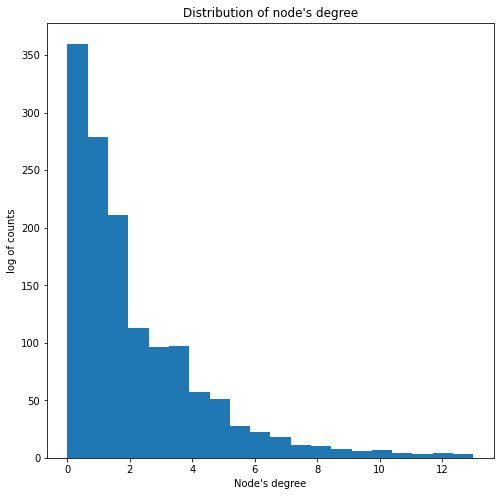

In [26]:
import matplotlib.pyplot as plt

uniq, counts = np.unique(degrees[degrees > 0], return_counts=True)

plt.figure(figsize=(8, 8))
plt.hist(np.log(counts), bins=20)
plt.xlabel("Node's degree")
plt.ylabel("log of counts")
plt.title("Distribution of node's degree")
plt.show()


In [27]:
class ImplicitALS_Loss(nn.Module):
    def __init__(self, l, degrees):
        super().__init__()
        self.l = l
        self.degrees = degrees
        self.mse = nn.MSELoss()

    def forward(self, output, embeddings, target, vertexes):
        cur_c = torch.tensor([self.degrees[vertexes[i][0].item()] + self.degrees[vertexes[i][1].item()] for i in range(vertexes.shape[0])]).to(device)
        return torch.mean(cur_c * torch.sum((output + 0.0 - target) ** 2, -1)) + self.l * self.mse(embeddings + 0.0,  embeddings  + 0.0)

In [28]:
criterion = ImplicitALS_Loss(10, degrees)
model = SLIM(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 

In [29]:
from tqdm.auto import tqdm, trange

EPOCHS = 5
losses = []


for _ in trange(EPOCHS):
    pbar = tqdm(loader)
    for batch in pbar:
        optimizer.zero_grad()
        batch = batch.to(device)
        edge, target = batch[:, :2], batch[:, 2:]
        output, embeddings = model(edge)
        loss = criterion(output, embeddings, target, edge)
        pbar.set_description(f"Train loss: {loss.item()}")
        loss.backward()
        losses.append(loss.item())
        optimizer.step() 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

In [30]:
import pickle


torch.save(model, "implicitals.pt")
with open("implicitals_losses.txt", 'wb') as f:
    pickle.dump(losses, f)

In [31]:
model_adapter = ModelAdapter(model).to(device)
graph_manager.inference_model(model_adapter, 50, 20, 3, 30, 15000)  

  0%|          | 0/15000 [00:00<?, ?it/s]

6.910477537497069e-06

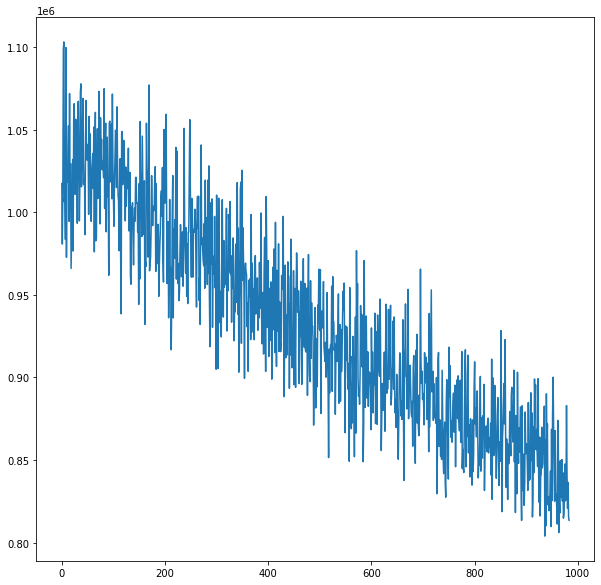

In [32]:
def mean_window(arr, window_size):
    answers = []
    for i in range(len(arr) // window_size - 1):
        start_ind = i * window_size
        end_ind = start_ind + window_size
        answers.append(sum(arr[start_ind:end_ind]) / window_size)
    return answers


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
cur_losses = mean_window(losses, 100)
plt.plot(np.arange(len(cur_losses)), cur_losses)
plt.show()


## SVD++

In [33]:
class SVDPlusPlus(nn.Module):
    def __init__(self, hidden_dim = 64):
        super().__init__()
        self.embedding = nn.Embedding(N_TOTAL, hidden_dim)
        self.embeddings_b = nn.Embedding(N_TOTAL, 1)


    def forward(self, input):
        input_embeddings = self.embedding(input) #b, 2, h
        input_b = self.embeddings_b(input)
        u, v = input_embeddings[:, 0, :], input_embeddings[:, 1, :]
        u_b, v_b = input_b[:, 0, 0], input_b[:, 1, 0]
        return u_b + v_b + torch.sum(u * v, -1), input_embeddings, input_b


In [34]:
class SVDPlusPlusLoss(nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        self.mse = nn.MSELoss()

    def forward(self, output, embeddings, embeddings_b, target):
        return self.mse(output + 0.0, target + 0.0) + self.b * (self.mse(embeddings + 0.0,  embeddings  + 0.0) + self.mse(embeddings_b + 0.0, embeddings_b + 0.0))

In [35]:
criterion = SVDPlusPlusLoss(0.1)
model = SVDPlusPlus(64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) 

In [36]:
from tqdm.auto import tqdm, trange

EPOCHS = 5
losses = []


for _ in trange(EPOCHS):
    pbar = tqdm(loader)
    for batch in pbar:
        optimizer.zero_grad()
        batch = batch.to(device)
        edge, target = batch[:, :2], batch[:, 2:]
        output, embeddings, embeddings_b = model(edge)
        loss = criterion(output, embeddings, embeddings_b, target)
        pbar.set_description(f"Train loss: {loss.item()}")
        loss.backward()
        losses.append(loss.item())
        optimizer.step() 


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

  0%|          | 0/19707 [00:00<?, ?it/s]

In [37]:
import pickle


torch.save(model, "svdplusplus.pt")
with open("svdplusplus_losses.txt", 'wb') as f:
    pickle.dump(losses, f)